# Libraries

In [1]:
import requests
from datetime import date, timedelta
import logging
import matplotlib.pyplot as plt

# Set up logging

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO)

# Suppress matplotlib info messages
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# Functions

In [3]:
def fetch_exchange_rate_for_date(base_url, date_str, params):
    """
    Description: fetches exchange rate data for a specific date.
    base_url: url to passed into GET request.
    date_str: a date with a string data type to in the format 'YYYY-MM-DD'.
    params: query parametres to passed ino the GET request.
    """
    # Append date to historical endpoint url
    url = f"{base_url}{date_str}"
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an error for bad status codes
        
        data = response.json()
        
        # Check if expected keys are present. If they are, extract required data
        if 'date' in data and 'rates' in data:
            return {
                'date': data['date'],
                'rates': data['rates']
            }
        else:
            logging.error(f"Missing expected data keys for {date_str}: {data}")
    except requests.exceptions.RequestException as e:
        logging.error(f"Request failed for {date_str}: {e}")
        return None
    return None

def get_past_exchange_data(base_currency='AUD', target_currency='NZD', days=30):
    """
    Description: retrieves the last `days` worth of exchange rate data from current date.
    base_currency: currency converting from.
    target_currency: currency converting to.
    days: integer specifying the number days from current date to fetch exchange rate data. 
    """

    # Ensure that arguements are of the correct data type before proceeding.
    if not isinstance(base_currency, str):
        raise TypeError(f"base_currency must be a string, but got {type(base_currency).__name__}")
    if not isinstance(target_currency, str):
        raise TypeError(f"target_currency must be a string, but got {type(target_currency).__name__}")
    if not isinstance(days, int):
        raise TypeError(f"days must be an integer, but got {type(days).__name__}")

    base_url = 'https://api.exchangeratesapi.io/v1/'
    params = {
        'access_key': '59b7b82249656f7c7a51f9d9cc13a3eb', #ideally, access key would be stored in a key vault.
        'base': base_currency,
        'symbols': target_currency
    }
    
    # Set today's date
    end_date = date.today()

    # Calculate the date x number of days ago (x = days)
    start_date = end_date - timedelta(days=days-1)  # Adjust for inclusive range

    #Initialize a list to store responses
    response_list = []

    current_date = start_date

    while current_date <= end_date:
        # Converts date object into string
        date_str = current_date.isoformat()

        # Fetch data
        exchange_rate_data = fetch_exchange_rate_for_date(base_url, date_str, params)

        if exchange_rate_data: # Check if data was retrieved 
            response_list.append(exchange_rate_data)
        
        current_date += timedelta(days=1)
    
    return response_list

def find_best_and_worst_rates(exchange_data):
    """
    Description: Finds the best (highest) and worst (lowest) exchange rates in the provided data.
    exchange_data: a list of dictionaries containing exchange rate info. To be used with get_past_exchange_data() output.
    """
    # Check if exchange_data is empty.
    if not exchange_data:
        return None, None
    
    # Initialize variables to track extremes.
    best_rate = float('-inf') # Ensures any exchange rate encoutered during iteration will be greater than negative infinity, allowing it to be updated
    worst_rate = float('inf') # Ensures any exchange rate encoutered during iteration will be less than positive infinity, allowing it to be updated
    best_date = None
    worst_date = None

    # Perform iteration to get best and worst rates and the respective dates they occured on.
    for entry in exchange_data:
        date = entry['date']
        rate = entry['rates']['NZD']
        
        if rate > best_rate:
            best_rate = rate
            best_date = date
        
        if rate < worst_rate:
            worst_rate = rate
            worst_date = date
    
    return {'date': best_date, 'rate': best_rate}, {'date': worst_date, 'rate': worst_rate}

def calculate_average_rate(exchange_data):
    """
    Calculates the average exchange rate for the provided data.
    exchange_data: a list of dictionaries containing exchange rate info. To be used with get_past_exchange_data() output.
    """
    # Check if exchange_data is empty.
    if not exchange_data:
        return None
    
    total_rate = 0
    count = 0
    
    for entry in exchange_data:
        rate = entry['rates']['NZD']
        total_rate += rate
        count += 1
    
    average_rate = total_rate / count
    return average_rate

def plot_exchange_rates(exchange_data):
    """
    Description: plots the exchange rate data and highlights the best and worst rates.
    exchange_data: a list of dictionaries containing exchange rate info. To be used with get_past_exchange_data() output.
    """
    dates = [entry['date'] for entry in exchange_data]
    rates = [entry['rates']['NZD'] for entry in exchange_data]

    best_rate, worst_rate = find_best_and_worst_rates(exchange_data)

    plt.figure(figsize=(13, 7))
    plt.plot(dates, rates, label='Exchange Rate', marker='o')

    if best_rate:
        plt.plot(best_rate['date'], best_rate['rate'], 'go', label='Best Rate')
        plt.text(best_rate['date'], best_rate['rate'], f"Best: {best_rate['rate']}", fontsize=9, ha='right')

    if worst_rate:
        plt.plot(worst_rate['date'], worst_rate['rate'], 'ro', label='Worst Rate')
        plt.text(worst_rate['date'], worst_rate['rate'], f"Worst: {worst_rate['rate']}", fontsize=9, ha='right')

    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (AUD-NZD)')
    plt.title('AUD-NZD exchange Rate over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():

    # Call the function to fetch the past exchange rate data
    data = get_past_exchange_data()
    
    # Find the best and worst exchange rates
    best_rate, worst_rate = find_best_and_worst_rates(data)
    print(f"Best rate: {best_rate}")
    print(f"Worst rate: {worst_rate}")

    # Calculate the average exchange rate
    average_rate = calculate_average_rate(data)
    print(f"Average rate: {average_rate}")

    # Plot exchange rate data
    plot_exchange_rates(data)
    

# Output

In [4]:
# Call the function to fetch the past exchange rate data
data = get_past_exchange_data()

# Preview retrieved data 
data

[{'date': '2024-06-01', 'rates': {'NZD': 1.083895}},
 {'date': '2024-06-02', 'rates': {'NZD': 1.082492}},
 {'date': '2024-06-03', 'rates': {'NZD': 1.080211}},
 {'date': '2024-06-04', 'rates': {'NZD': 1.076407}},
 {'date': '2024-06-05', 'rates': {'NZD': 1.074255}},
 {'date': '2024-06-06', 'rates': {'NZD': 1.07631}},
 {'date': '2024-06-07', 'rates': {'NZD': 1.074866}},
 {'date': '2024-06-08', 'rates': {'NZD': 1.07895}},
 {'date': '2024-06-09', 'rates': {'NZD': 1.07808}},
 {'date': '2024-06-10', 'rates': {'NZD': 1.078204}},
 {'date': '2024-06-11', 'rates': {'NZD': 1.075373}},
 {'date': '2024-06-12', 'rates': {'NZD': 1.077024}},
 {'date': '2024-06-13', 'rates': {'NZD': 1.076672}},
 {'date': '2024-06-14', 'rates': {'NZD': 1.075134}},
 {'date': '2024-06-15', 'rates': {'NZD': 1.073361}},
 {'date': '2024-06-16', 'rates': {'NZD': 1.077516}},
 {'date': '2024-06-17', 'rates': {'NZD': 1.079063}},
 {'date': '2024-06-18', 'rates': {'NZD': 1.084816}},
 {'date': '2024-06-19', 'rates': {'NZD': 1.087336

Best rate: {'date': '2024-06-30', 'rate': 1.098744}
Worst rate: {'date': '2024-06-15', 'rate': 1.073361}
Average rate: 1.0832808


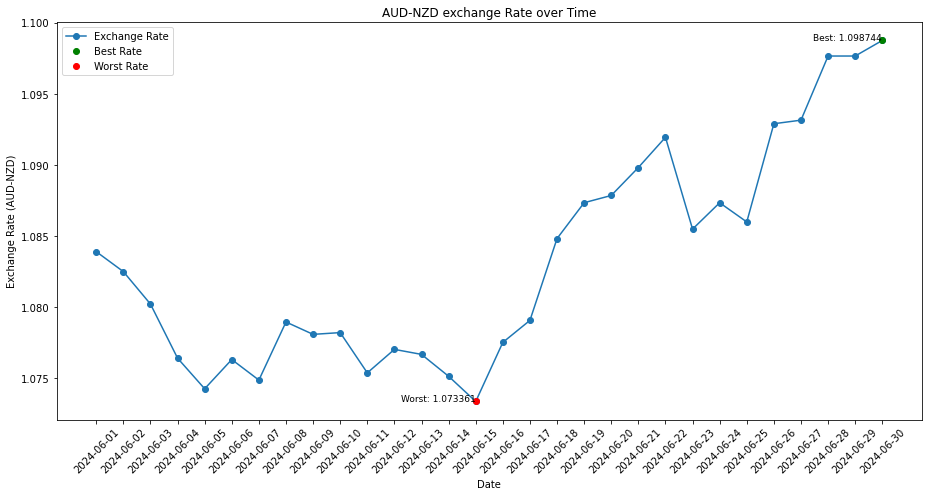

In [5]:
if __name__ == "__main__":
    main()